## Payment funnel analysis with multiple CTEs

**Business problem:**

The product manager has requested a payment funnel analysis from the analytics team; she wants to understand what the furthest point in the payment process users are getting to and where users are falling out of the process. She wants to have full visibility into each possible stage of the payment process from the user's point of view. 

Here's the payment process a user goes through when signing up for a subscription:

1. The user opens the widget to initiate payment process.
2. The user types in credit card information.
3. The user clicks the submit button to complete their part of the payment process.
4. The product sends the data to the third-party payment processing company.
5. The payment company completes the transaction and reports back with "complete."

This process is converted into `statusid` s using the following mapping in the statusdefinition table below:

`select * from statusdefinition;`
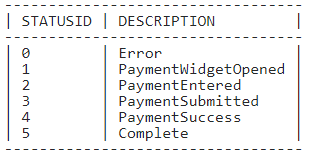

As subscriptions move through the statuses, the movements are logged in the `paymentstatuslog` table using the `statusid` . Users can go back and forth and move through statuses multiple times. Check out the example below for  `subscriptionid = '38844'` . Notice how they move through a few statuses, hit an error, restart the process, and then finally complete their payment.

```
select *
from paymentstatuslog
where subscriptionid = '38844'
order by movementdate;
```
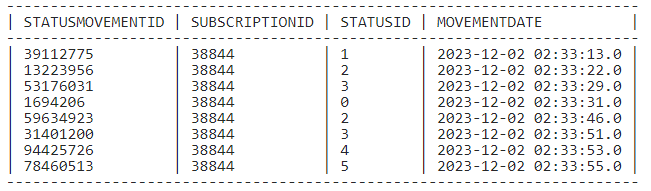

**Creating the paymentfunnelstage logic:**

I've given you the code for the `paymentfunnelstage` column, but here's the logic behind it. You're welcome to use the code I've given you or write it yourself using the funnel diagram provided.

To determine a subscription's `paymentfunnelstage` , we want to consider its **max** `statusid` because this will show us the **furthest** point in the workflow that they successfully reached—regardless of whether they:

- completed the process, 
- hit an error and started the process over,
- or hit an error, gave up, and left the workflow.

In addition to the max status reached, we also want to consider if the subscription is **currently** stuck in an error using the `currentstatus` column from the `subscriptions` table

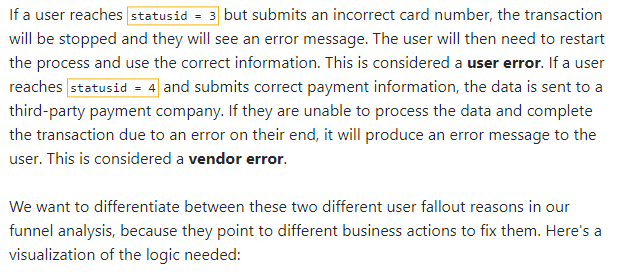

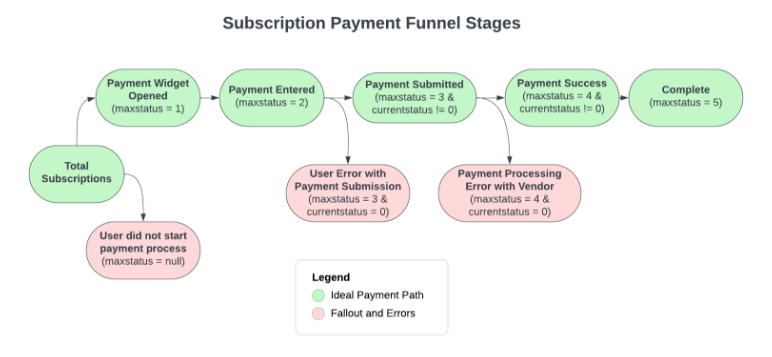

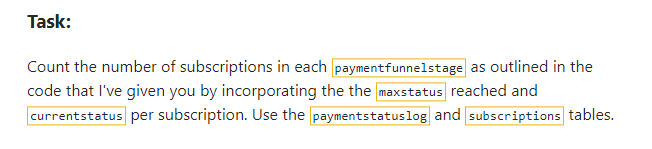

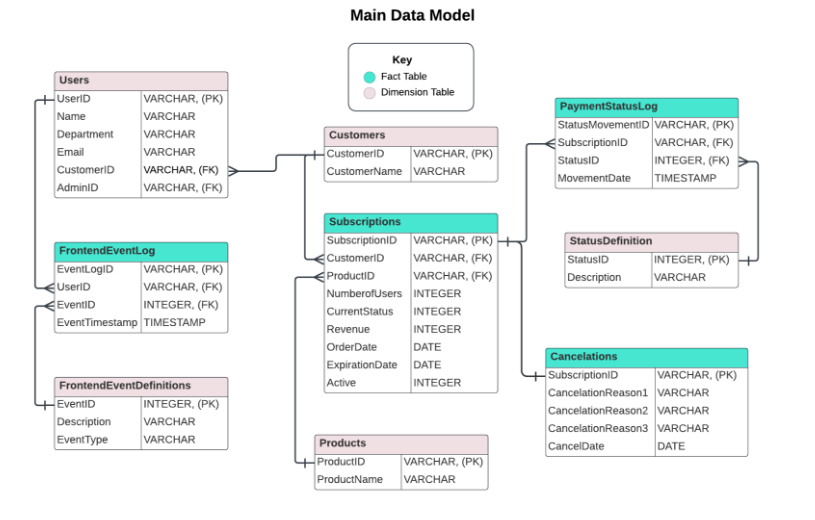

In [ ]:
-- first created a cte to pull the max status for each subscriber id
-- joined the subscriptions and paymentstatuslog tables in order to include the subscribers with no max values (if any)
with maxstatustable as (
 select s.subscriptionid,
 	max(statusid) as maxstatus,
	from subscriptions as s left join paymentstatuslog as p 
			on s.subscriptionid = p.subscriptionid 
	group by s.subscriptionid
),
-- then created another cte to pull the current status 
-- (actually this was not needed since the current status is already available in the data but this was a good practice)
currentstatustable as (
	with rankeddata as (
		select p.statusid,
			s.subscriptionid,
        -- here using the row_number window function to pull the most recent status based on the movementdate table. 
        -- ordered the dates so that the most recent one was on top and then we will pull the status from the first row
			row_number() over (partition by p.subscriptionid order by p.movementdate desc) as rn
		from subscriptions as s 
	left join paymentstatuslog as p
	on s.subscriptionid = p.subscriptionid
	)
	select subscriptionid,
	statusid as currentstatus
	from rankeddata
	where rn =1  -- this will provide the most recent status
)
 -- case statement explains the funnel stage logic 
 
select case when maxstatus = 1 then 'PaymentWidgetOpened'
		when maxstatus = 2 then 'PaymentEntered'
		when maxstatus = 3 and currentstatus = 0 then 'User Error with Payment Submission'
		when maxstatus = 3 and currentstatus != 0 then 'Payment Submitted'
		when maxstatus = 4 and currentstatus = 0 then 'Payment Processing Error with Vendor'
		when maxstatus = 4 and currentstatus != 0 then 'Payment Success'
		when maxstatus = 5 then 'Complete'
		when maxstatus is null then 'User did not start payment process'
		end as paymentfunnelstage,
        
        -- counting the subscription ids for each status
		count(distinct m.subscriptionid) as subscriptions
        -- joining the subscriptions table and the maxstatustable from the cte in order the include null values 
        -- where a user did not start the paymnet process
		from subscriptions as s left join maxstatustable as m 
			on s.subscriptionid = m.subscriptionid
            -- aggregating by funnel stage
		group by paymentfunnelstage



# Output: 

